In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import torch
from torch.utils.data import DataLoader
from train import get_model_class
%load_ext autoreload
%autoreload 2

In [3]:
random_sources = ['rs', 'loo']

In [4]:
name = 'heloc'  # or 'german'
n_models = 100  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
directory = f'models/{name}'
directory

'models/heloc'

### Compute and save predictions from models

In [5]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        pred = model.predict(X_test)
        np.save(f'{directory}/{random_source}_preds_{i}.npy', pred)

### Compute and save gradients from models

In [24]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        grads = model.compute_gradients(X_test, softmax=False, return_numpy=True)
        np.save(f'{directory}/{random_source}_grads_{i}.npy', grads)

### How to load/visualize gradients

In [30]:
# Set ensemble size
size_ensemble = 10

In [31]:
# Randomly sample size_ensemble indices from 0 to n_models
indices = np.random.choice(n_models, size_ensemble, replace=False)
indices

array([99, 68, 54, 63, 12, 36, 28, 75, 73, 20])

In [32]:
# Load predictions and gradients for models with those indices
preds = np.array([np.load(f'{directory}/{random_source}_preds_{i}.npy') for i in indices])
grads = np.array([np.load(f'{directory}/{random_source}_grads_{i}.npy') for i in indices])

In [33]:
# grads has size (size_ensemble, n_inputs, n_features) for tabular data
n_inputs, n_features = grads.shape[1:]
n_inputs, n_features

(1975, 23)

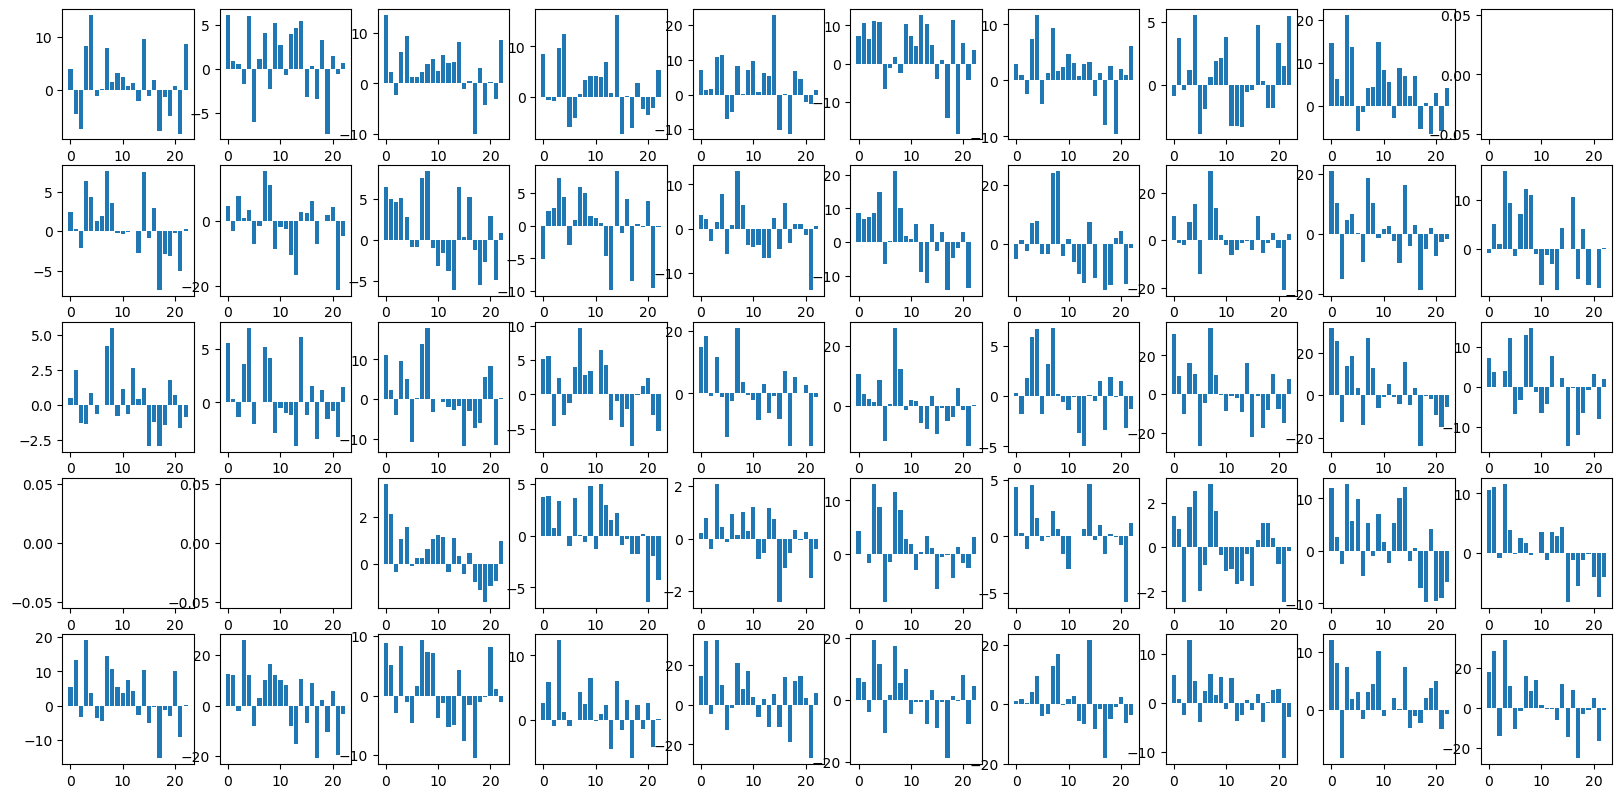

In [34]:
# Visualize gradients for each of the models in the ensemble for first 5 inputs
# Rows are inputs, columns are models
rows = 5
fig, axs = plt.subplots(rows, size_ensemble, figsize=(rows*4, size_ensemble), dpi=100)
for i in range(5):
    for j in range(size_ensemble):
        axs[i,j].bar(range(n_features), grads[j,i])
plt.show()

Okay so some gradients are zero... moreso if you do softmax gradient instead of logit gradient

Might just be a floating point error (could try float64 instead of float32 but will double the storage size)

softmax gradient and logit gradient should be the same (?), just softmax is magnitudes smaller